# 01. PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

In [1]:
import torch
from torch import nn ## nn contains all of PyTorch's buildinig blocks and Neural Networks
import matplotlib.pyplot as plt

In [2]:
what_are_we_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

# Data (preparing and loading)

Data can be almost anything... in machine learning

* Excel spreadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical represetantion.

To showcase this, let's create som *known* data using a linear regression formula.

We'll use a linear regression formula to make a straight line wuth *known* **parameters**.

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

## Splitting data into training and test sets

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How to better visualize our data?

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="#1500c9", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="#00c90d", s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exists
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})


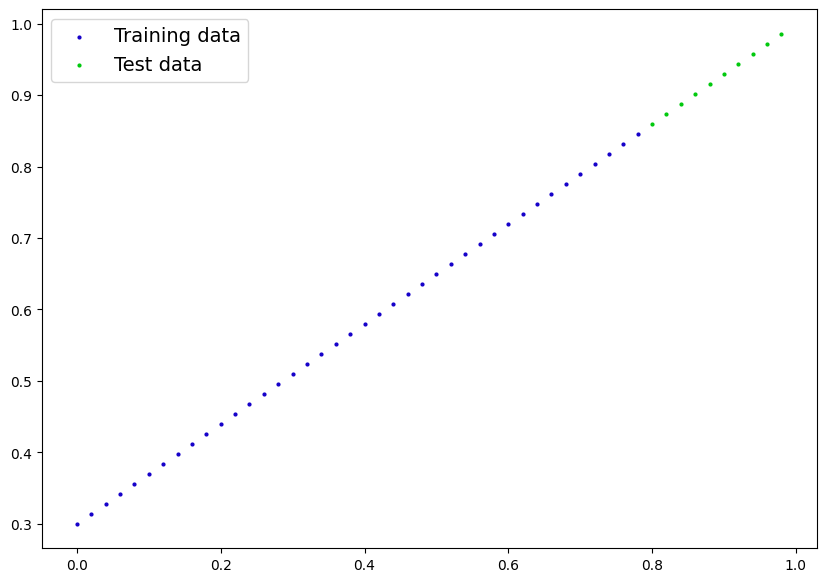

In [7]:
plot_predictions()

## Building a model

In [8]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module): # <- almosth everything in PyTorch inherits from nn.module
  def __init__(self):
    super.__init__()
    self.weight = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float32
                                           ))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float32
                                         ))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weight * x + self.bias